In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

C:\Users\surface\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\surface\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\surface\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


C:\Users\surface\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: covariance is not positive-semidefinite.


Text(0.5, 1.0, 'velocity')

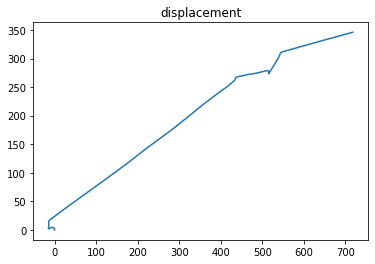

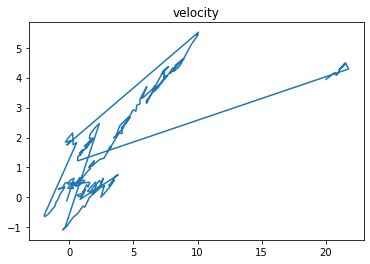

In [56]:
l = 0.01
c = 20
N = 200
delta_t = 1
sigma_w = 0.033
mu_w1 = 0.1
mu_w2 = 0.05
alpha = 1.6

def simu_langevin_non_zero():
    x = np.matrix([0,0,0,0]).T # vertical matrix
    x_test = np.matrix([0,0,0,0]).T
    x_ns = np.zeros((N,4))
    t_ns = np.zeros(N)

    x_ns_test = np.zeros((N,4))

    for n in range(N):
        gamma = 0

        m_c_dt = 0
        s_c_dt = 0
        while gamma<c*delta_t:
            delta_gamma = np.random.exponential(scale = 1.0)
            gamma = gamma+delta_gamma

            v_i = np.random.uniform(0,delta_t)
            while v_i==0:
                v_i = np.random.uniform(0,delta_t) # need to make sure v_i is non-zero

            # calculate mean delta t^c      
            f1 = -np.exp(-l*(delta_t-v_i))/l+1/l
            f2 = np.exp(-(delta_t-v_i)*l)
            f_delta_t_v_i_m = np.matrix([f1,f2,f1,f2]).T
            f_delta_t_v_i = np.matrix([[f1,0],[f2,0],[0,f1],[0,f2]])
            m_c_dt += delta_t**(1/alpha)*gamma**(-1/alpha)*f_delta_t_v_i_m
            s_c_dt += delta_t**(2/alpha)*gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)


        q12 = -1/(2*l**2)*(1-np.exp(-2*delta_t*l))+(1-np.exp(-delta_t*l))/l**2
        q22 = (1-np.exp(-2*delta_t*l))/(2*l)
#         Q_delta_t = np.matrix([[0,q12*(sigma_w**2+mu_w1**2),0,0],[0,q22*(sigma_w**2+mu_w1**2),0,0],
#                                [0,0,0,q12*(sigma_w**2+mu_w2**2)],[0,0,0,q22*(sigma_w**2+mu_w2**2)]])
        Q_delta_t = np.matrix([[0,q12*sigma_w**2,0,0],[0,q22*(sigma_w**2),0,0],
                               [0,0,0,q12*(sigma_w**2)],[0,0,0,q22*(sigma_w**2)]])
        S_delta_t = sigma_w**2*s_c_dt + alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t

        m12 = -(np.exp(-delta_t*l)-1)/l
        m22 = np.exp(-delta_t*l)
        # centering term
        c1 = -(1-np.exp(-l*delta_t))/l**2 + delta_t/l
        c2 = (1-np.exp(-l*delta_t))/l
        Z_c_bar = alpha/(alpha-1)*c**(1-1/alpha)* np.matrix([mu_w1*c1,mu_w1*c2,mu_w2*c1,mu_w2*c2]).T

        m_delta_t_test = np.matmul(np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]]),x)
        m_c_dt[0:2] *= mu_w1
        m_c_dt[2:] *= mu_w2
        m_delta_t = np.matmul(np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]]),x)+m_c_dt


        if alpha > 1:
            m_delta_t -= Z_c_bar

        x = np.random.multivariate_normal(np.array(m_delta_t.T)[0], S_delta_t.T) # horizontal array

        x_ns[n,:]=x
        x = np.matrix(x).T # transform x to be a vertical matrix
        t_ns[n]=n*delta_t
        
    return x_ns, t_ns

x_ns, t_ns = simu_langevin_non_zero()
plt.figure()
plt.plot(x_ns[:,0], x_ns[:,2])  
# plt.plot(x_ns_test[:,0], x_ns_test[:,2])  
plt.title('displacement') 
# plt.legend(['test','true'])

plt.figure()
plt.plot(x_ns[:,1], x_ns[:,3])  
# plt.plot(x_ns_test[:,1], x_ns_test[:,3])  
plt.title('velocity') 
# plt.legend(['test','true'])


C:\Users\surface\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: covariance is not positive-semidefinite.


Text(0.5, 1.0, 'Mean of noise')

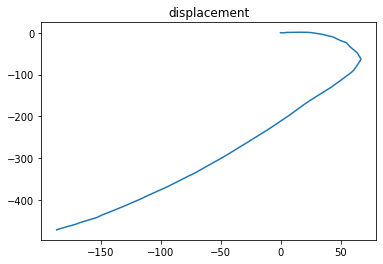

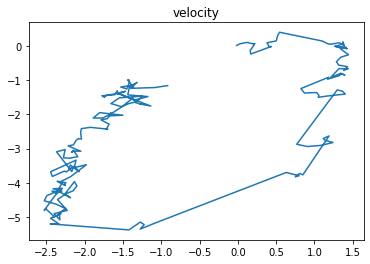

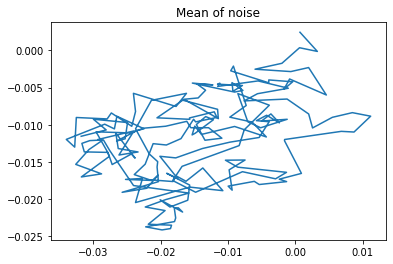

In [49]:
sigma_mu1 = 0.003
sigma_mu2 = 0.0015
alpha = 1.7

def simu_langevin_changing_mu():
    x = np.matrix([0,0,0,0]).T # vertical matrix
    x_ns = np.zeros((N,4))
    t_ns = np.zeros(N)
    u_ns = np.zeros((N,2))

    u1 = 0.0 # start of u
    u2 = 0.0

    for n in range(N):
        gamma = 0

        m_c_dt = 0
        s_c_dt = 0
       
        vs = []
        gammas = []
        while gamma<c*delta_t:
            delta_gamma = np.random.exponential(scale = 1.0)
            gamma = gamma+delta_gamma

            v_i = np.random.uniform(0,delta_t)
            while v_i==0:
                v_i = np.random.uniform(0,delta_t) # need to make sure v_i is non-zero
               
            vs.append(v_i)
            gammas.append(gamma)
       
        # sort v, gamma with increasing v
        gammas = [x for _, x in sorted(zip(vs, gammas), key=lambda pair: pair[0])]
        vs.sort()
        v0 = 0.0
        avg_mu1 = 0.0
        avg_mu2 = 0.0
           
        for v_i, gamma in zip(vs, gammas):
            # generate u, as a brownian motion
            u1_i = np.random.normal(u1, sigma_mu1*np.sqrt(v_i-v0))
            u2_i = np.random.normal(u2, sigma_mu2*np.sqrt(v_i-v0))
            # mean of mu
            avg_mu1 += (v_i-v0)*u1_i
            avg_mu2 += (v_i-v0)*u2_i

            # calculate mean delta t^c      
            f1 = -np.exp(-l*(delta_t-v_i))/l+1/l
            f2 = np.exp(-(delta_t-v_i)*l)
            f_delta_t_v_i_m = np.matrix([f1,f2,f1,f2]).T
            f_delta_t_v_i = np.matrix([[f1,0],[f2,0],[0,f1],[0,f2]])
           
            # mean
            m_c_dt_i = delta_t**(1/alpha)*gamma**(-1/alpha)*f_delta_t_v_i_m
            m_c_dt_i[0:2] *= u1_i
            m_c_dt_i[2:] *= u2_i
            m_c_dt += m_c_dt_i
           
            # variance
            s_c_dt += delta_t**(2/alpha)*gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)
           
            # updata variables
            u1 = u1_i
            u2 = u2_i
            v0 = v_i

        # generate last u_n
        u1 = np.random.normal(u1, sigma_mu1*np.sqrt(delta_t-v0))
        u2 = np.random.normal(u2, sigma_mu2*np.sqrt(delta_t-v0))
        u_ns[n,0] = u1
        u_ns[n,1] = u2
       
        # calculate average mu for mean calculation later
        avg_mu1/= delta_t
        avg_mu2/= delta_t

        q12 = -1/(2*l**2)*(1-np.exp(-2*delta_t*l))+(1-np.exp(-delta_t*l))/l**2
        q22 = (1-np.exp(-2*delta_t*l))/(2*l)
        Q_delta_t = np.matrix([[0,q12,0,0],[0,q22,0,0],
                               [0,0,0,q12],[0,0,0,q22]])
        Q_delta_t[:2,:2]*= (delta_t*sigma_mu1**2+sigma_w**2)
        Q_delta_t[2:,2:]*= (delta_t*sigma_mu2**2+sigma_w**2)
        S_delta_t = sigma_w**2*s_c_dt + alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t

        m12 = -(np.exp(-delta_t*l)-1)/l
        m22 = np.exp(-delta_t*l)
        # centering term
        c1 = -(1-np.exp(-l*delta_t))/l**2 + delta_t/l
        c2 = (1-np.exp(-l*delta_t))/l
        Z_c_bar = alpha/(alpha-1)*c**(1-1/alpha)* np.matrix([avg_mu1*c1,avg_mu1*c2,avg_mu2*c1,avg_mu2*c2]).T

        m_delta_t = np.matmul(np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]]),x)+m_c_dt


        if alpha > 1:
            m_delta_t -= Z_c_bar

        x = np.random.multivariate_normal(np.array(m_delta_t.T)[0], S_delta_t.T) # horizontal array

        x_ns[n,:]=x
        x = np.matrix(x).T # transform x to be a vertical matrix
        t_ns[n]=n*delta_t
       
    return x_ns, t_ns, u_ns

x_ns, t_ns, u_ns = simu_langevin_changing_mu()
plt.figure()
plt.plot(x_ns[:,0], x_ns[:,2])  
# plt.plot(x_ns_test[:,0], x_ns_test[:,2])  
plt.title('displacement') 
# plt.legend(['test','true'])

plt.figure()
plt.plot(x_ns[:,1], x_ns[:,3])  
# plt.plot(x_ns_test[:,1], x_ns_test[:,3])  
plt.title('velocity') 
# plt.legend(['test','true'])

plt.figure()
plt.plot(u_ns[:,0], u_ns[:,1])
plt.title('Mean of noise')

In [37]:
# tracking zero-mean langevin, alpha stable
def sampling_latent_variables_zeromean(delta_t, sigma_w, alpha, u1, u2): # need previous estimation of u
    gammas = []
    vs = []
    
    gamma = 0
    m_c_dt = 0
    s_c_dt = 0

    while gamma<c*delta_t:
        delta_gamma = np.random.exponential(scale = 1.0)
        gamma = gamma+delta_gamma

        v_i = np.random.uniform(0,delta_t)
        while v_i==0:
            v_i = np.random.uniform(0,delta_t) # need to make sure v_i is non-zero

        vs.append(v_i)
        gammas.append(gamma)
       
    # sort v, gamma with increasing v
    gammas = [x for _, x in sorted(zip(vs, gammas), key=lambda pair: pair[0])]
    vs.sort()
    v0 = 0.0
    avg_mu1 = 0.0
    avg_mu2 = 0.0

    for v_i, gamma in zip(vs, gammas):
        # generate u, as a brownian motion
        u1_i = np.random.normal(u1, sigma_mu1*np.sqrt(v_i-v0))
        u2_i = np.random.normal(u2, sigma_mu2*np.sqrt(v_i-v0))
        # mean of mu
        avg_mu1 += (v_i-v0)*u1_i
        avg_mu2 += (v_i-v0)*u2_i

        # calculate mean delta t^c      
        f1 = -np.exp(-l*(delta_t-v_i))/l+1/l
        f2 = np.exp(-(delta_t-v_i)*l)
        f_delta_t_v_i_m = np.matrix([f1,f2,f1,f2]).T
        f_delta_t_v_i = np.matrix([[f1,0],[f2,0],[0,f1],[0,f2]])

        # mean
        m_c_dt_i = delta_t**(1/alpha)*gamma**(-1/alpha)*f_delta_t_v_i_m
        m_c_dt_i[0:2] *= u1_i
        m_c_dt_i[2:] *= u2_i
        m_c_dt += m_c_dt_i

        # variance
        s_c_dt += delta_t**(2/alpha)*gamma**(-2/alpha)*np.matmul(f_delta_t_v_i,f_delta_t_v_i.T)

        # updata variables
        u1 = u1_i
        u2 = u2_i
        v0 = v_i
    
    # calculate average mu for mean calculation later
    avg_mu1/= delta_t
    avg_mu2/= delta_t
    
    # centering term
    c1 = -(1-np.exp(-l*delta_t))/l**2 + delta_t/l
    c2 = (1-np.exp(-l*delta_t))/l
#     import pdb;pdb.set_trace()
    Z_c_bar = alpha/(alpha-1)*c**(1-1/alpha)* np.matrix([avg_mu1*c1,avg_mu1*c2,avg_mu2*c1,avg_mu2*c2]).T
    
    return m_c_dt, s_c_dt, Z_c_bar, u1, u2, v_i

def single_ite_particle_filtering(y_n, log_weight_p, mu_p, P_p, mum_p, Pm_p, delta_t, sigma_w, alpha,l, noise_sig, resample = False):
    # mu_p = [mu1, mu2, .. muP], P_p = [P1, P2, .. PP]
    num_particles = len(mu_p) # list of list of lists, because length if each particle is not fixed, P*n*I
    if resample:
        indices = np.random.choice(list(range(num_particles)), size = num_particles, p = np.exp(log_weight_p))
        mu_p = [mu_p[i] for i in indices]
        P_p = [P_p[i] for i in indices]
        
        mum_p = [mum_p[i] for i in indices]
        Pm_p = [Pm_p[i] for i in indices]

        log_weight_p = np.log(np.ones(num_particles)*(1/num_particles))
    
    R = np.identity(4)*noise_sig**2
    R[1,1] /= 20
    R[3,3] /= 20
    
    mu_p_nextn = []
    P_p_nextn = []
    mum_p_nextn = []
    Pm_p_nextn = []
    log_weights_p_nextn = np.ones(num_particles)
    
    q12 = -1/(2*l**2)*(1-np.exp(-2*delta_t*l))+(1-np.exp(-delta_t*l))/l**2
    q22 = (1-np.exp(-2*delta_t*l))/(2*l)
    Q_delta_t = np.matrix([[0,q12,0,0],[0,q22,0,0],
                           [0,0,0,q12],[0,0,0,q22]])
    Q_delta_t[:2,:2]*= (delta_t*sigma_mu1**2+sigma_w**2)
    Q_delta_t[2:,2:]*= (delta_t*sigma_mu2**2+sigma_w**2)
    
    m12 = -(np.exp(-delta_t*l)-1)/l
    m22 = np.exp(-delta_t*l)
    A = np.matrix([[1,m12,0,0],[0,m22,0,0],[0,0,1,m12],[0,0,0,m22]])
    for p in range(num_particles):
        u1 = mum_p[p][0]
        u2 = mum_p[p][1]
        m_c_dt, s_c_dt, Z_c_bar, u1, u2, v_i = sampling_latent_variables_zeromean(delta_t, sigma_w, alpha, u1, u2)
#         s_c_dt = delta_t**(2/alpha)*jump_sum
        S = sigma_w**2*s_c_dt + alpha/(2-alpha)*c**(1-2/alpha)*Q_delta_t
#         S = jump_sum
        
        # update state, x, according to y, observation
        mu_n_prev_n = np.matmul(A,mu_p[p])
        P_n_prev_n = A*P_p[p]*A.T + S

        y_hat_n_prev_n = mu_n_prev_n
        sigma_n_prev_n = P_n_prev_n + R
        K = P_n_prev_n*np.linalg.inv(sigma_n_prev_n)
        P_n_n = (np.identity(4) - K)*P_n_prev_n
        mu_n_n = P_n_n*(np.linalg.inv(P_n_prev_n)*mu_n_prev_n + np.linalg.inv(R)*y_n)
        
        mu_p_nextn.append(mu_n_n)
        P_p_nextn.append(P_n_n)
        
        # update mus
        mum_p_nextn.append(np.array([u1, u2]))
        Pm_p_nextn.append(Pm_p[p]+(delta_t - v_i)*np.matrix([[sigma_mu1**2, 0],[0,sigma_mu2**2]])) # increasing covariance..?
    
#         update weights
        log_w_p_nextn = log_weight_p[p]+np.log(stats.multivariate_normal(np.array(y_hat_n_prev_n.T)[0], sigma_n_prev_n).pdf(np.array(y_n.T)[0]))
#         log_w_p_nextn = np.log(np.ones(num_particles)*(1/num_particles))
        log_weights_p_nextn[p] = log_w_p_nextn
#         if np.isinf(log_w_p_nextn):
#             import pdb;pdb.set_trace()
    
    # normalise weights
    log_weights_p_nextn = log_weights_p_nextn-np.log(sum(np.exp(log_weights_p_nextn)))
    
#     weights_p_nextn = weights_p_nextn/sum(weights_p_nextn)
    
    return log_weights_p_nextn, mu_p_nextn, P_p_nextn,mum_p_nextn, Pm_p_nextn

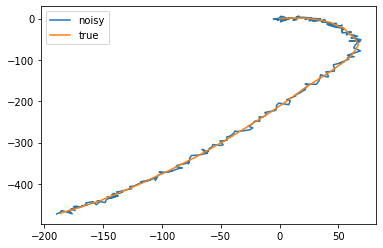

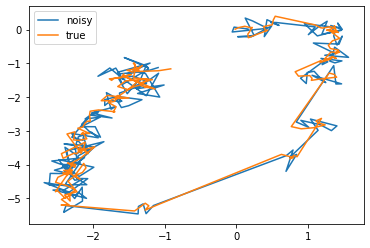

In [50]:
noise_sig = 3
noise = np.random.normal(0, noise_sig, (N, 4))
noise[:,1] /= 20
noise[:,3] /= 20
y_ns = x_ns+noise # noisy data
plt.figure()
plt.plot(y_ns[:,0], y_ns[:,2])
plt.plot(x_ns[:,0],x_ns[:,2])
plt.legend(['noisy', 'true'])
plt.figure()
plt.plot(y_ns[:,1], y_ns[:,3])
plt.plot(x_ns[:,1],x_ns[:,3])
plt.legend(['noisy', 'true'])

In [53]:
n_mus = []
n_Ps = []
n_mums = []
n_Pms = []
n_ws = []
num_particles = 10

# initialize x
mu_p = [np.matrix(np.zeros(4)).T]*num_particles
P_p = [np.matrix(np.identity(4))*10]*num_particles
mum_p = [np.zeros(2)]*num_particles
Pm_p = [np.matrix(np.identity(2))*1]*num_particles
weight_p = np.log(np.ones(num_particles)*(1/num_particles))
for n in range(N):

    y_n = np.matrix(y_ns[n]).T
    weight_p, mu_p, P_p, mum_p, Pm_p = single_ite_particle_filtering(y_n, weight_p, mu_p, P_p, mum_p, Pm_p, delta_t, sigma_w, alpha,l, noise_sig, resample = True)
    
    n_mus.append(mu_p)
    n_Ps.append(P_p)
    n_mums.append(mum_p)
    n_Pms.append(Pm_p)
    n_ws.append(weight_p)

n_mus = np.array(n_mus)
n_Ps = np.array(n_Ps)
n_mums = np.array(n_mums)
n_Pms = np.array(n_Pms)
n_ws = np.array(np.exp(n_ws))

(200, 10, 4, 1) (200, 10) (200, 10, 2)
1.4131248009631665


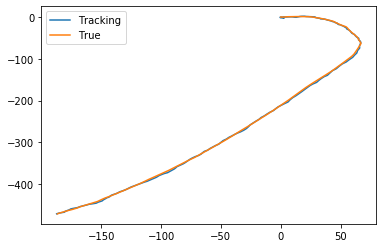

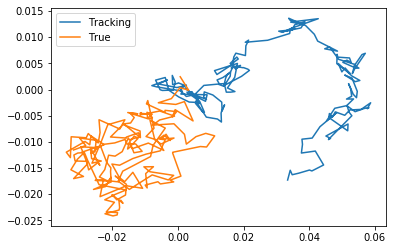

In [54]:
print(n_mus.shape, n_ws.shape, n_mums.shape)
average = np.zeros((N, 4))
avg_mus = np.zeros((N, 2))

for i in range(N):
    for d in range(4):
        average[i,d]=np.dot(np.array(n_mus[i,:,d,:].T)[0], n_ws[i,:])
    for d in range(2):
        avg_mus[i,d]=np.dot(n_mums[i,:,d], n_ws[i,:])

plt.figure()
plt.plot(average[:,0], average[:,2])
plt.plot(x_ns[:,0], x_ns[:,2])
plt.legend(['Tracking', 'True'])

plt.figure()
plt.plot(avg_mus[:,0], avg_mus[:,1])
plt.plot(u_ns[:,0], u_ns[:,1])
plt.legend(['Tracking', 'True'])
error = np.dot(average[:,0]-x_ns[:,0],average[:,0]-x_ns[:,0])/N
print(error)